In [226]:
import sys
import os
import shutil
import ftplib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import re
from contextlib import closing
import urllib.request as request
import numpy as np
import ahocorasick
from Bio import SeqIO
import hashlib
from pyteomics import mztab

In [209]:
'''
General
'''
#connect to ftp and get the list of samples
ftp_url = 'ftp.pride.ebi.ac.uk'
samples_dir = 'pride/data/proteomes/proteogenomics/cell-lines'
id_dir = 'proteomics_lfq'
triqler_file_name = 'out_triqler.tsv'
mzTab_file_name = 'out.mzTab'
output_file = 'identified_peptides.tsv'
contaminants = 'contaminants.fasta'
canonical_proteins_fasta = 'UniProtr11Dec2019+Ensembl103+GENCODE33+RefSeq29May2020.proteins.fasta'
peps_id_dir = 'peptide_ids'
checksums_file = 'checklist.chk'

#get all canonical sequences from fasta
allcan_seqs = []
parsed_file = SeqIO.parse(canonical_proteins_fasta,"fasta")
for record in parsed_file:
    allcan_seqs.append(str(record.seq))
allcan_seqs = list(set(allcan_seqs))

#get protein IDs from the contaminated database
conatm_ids = '|'.join([x.strip('>').split(' ')[0] for x in open(contaminants, 'r').readlines() if x.startswith('>')])

def rep(x):
    return re.sub('{[^}]*}', '', x.replace('(','{').replace(')', '}').replace('.',''))

In [210]:
#Get list of samples
try:
    ftp = ftplib.FTP(ftp_url, timeout=3600)
    ftp.login()
    ftplib.FTP.maxline = 100000
    ftp.cwd(samples_dir)
    samples_list = ftp.nlst()
except ftplib.all_errors:
    print('Failed to connect to the ftp site')

print("Number of Samples completed: " + str(len(samples_list)))

Number of Samples completed: 58


In [218]:
checksums = {}
try:
    lines = []
    ftp.retrlines('RETR {}'.format(checksums_file), lines.append)
    for line in lines:
        checksums[line.strip().split(' ')[-1].lstrip('./')] = line.strip().split(' ')[0]
except ftplib.error_perm as e: #the search is not done yet!
    print('Failed to get checksums file: {} in {}'.format(checksums_file, ftp.pwd(), e))

In [219]:
checksums

{'PXD005946-Sample-36/raw_ids/00296_E02_P001905_B00A_A00_R1_comet_idx_feat_perc.idXML': 'cbd75106fd85be871fa206f3e7f3f87d',
 'PXD005946-Sample-36/raw_ids/00296_C03_P001905_B00G_A00_R1_comet_idx_feat_perc.idXML': '3a760fe507711f51cffe2c7910c566b9',
 'PXD005946-Sample-36/raw_ids/00296_A03_P001905_B00E_A00_R1_comet_idx_feat_perc.idXML': 'ec116f8da059ff4a8eeef4fbb70262e8',
 'PXD005946-Sample-36/raw_ids/00296_D03_P001905_B00H_A00_R1_comet_idx_feat_perc.idXML': '5d7f25d7d9926c07b8ed8e49b1f91697',
 'PXD005946-Sample-36/raw_ids/00296_G02_P001905_B00C_A00_R1_comet_idx_feat_perc.idXML': '18344f345cebbc766cee11e47956e9df',
 'PXD005946-Sample-36/raw_ids/00296_H03_P001905_B00L_A00_R1_comet_idx_feat_perc.idXML': '57ae801d723589feb4c6e91b36aa04c6',
 'PXD005946-Sample-36/raw_ids/00296_H02_P001905_B00D_A00_R1_comet_idx_feat_perc.idXML': 'c5d55cf2a40c58ff76139c5eb220d27f',
 'PXD005946-Sample-36/raw_ids/00296_B03_P001905_B00F_A00_R1_comet_idx_feat_perc.idXML': '29de9fc4db2d2adb0a2aa69c7a5dcc2f',
 'PXD005

In [203]:
#extract peptides from triqler csv files

#get all peptides from the finished samples
triqler_peps_df = pd.DataFrame()
samples = []
for sample in samples_list:
    lines = []
    try:
        ftp.retrlines('RETR {}/{}/{}'.format(sample, id_dir, triqler_file_name), lines.append)
        this_peps_df = pd.DataFrame(data=[x.split('\t') for x in lines[1::]],
                          columns = lines[0].split('\t'))
        this_peps_df['Sample'] = sample
        print('Sample {}, #Peptides: {}'.format(sample, len(this_peps_df)))
    except ftplib.error_perm as e: #the search is not done yet!
        print('Sample: {}, error: {}'.format(sample, e))
        continue #to next sample
        
    triqler_peps_df = pd.concat([triqler_peps_df, this_peps_df])
    

Sample PXD003209-Sample-1, #Peptides: 5113
Sample PXD005698-Sample-1, #Peptides: 434
Sample PXD005698-Sample-2, #Peptides: 512
Sample: PXD005698-Sample-4, error: 550 Failed to open file.
Sample PXD005698-Sample-5, #Peptides: 440
Sample PXD005940-Sample-1, #Peptides: 17831
Sample PXD005940-Sample-2, #Peptides: 21963
Sample PXD005940-Sample-3, #Peptides: 15085
Sample PXD005940-Sample-4, #Peptides: 13230
Sample PXD005940-Sample-5, #Peptides: 16289
Sample PXD005940-Sample-6, #Peptides: 18161
Sample PXD005940-Sample-7, #Peptides: 17507
Sample PXD005940-Sample-8, #Peptides: 16489
Sample PXD005940-Sample-9, #Peptides: 11919
Sample PXD005942-Sample-1, #Peptides: 535
Sample PXD005942-Sample-12, #Peptides: 511
Sample PXD005942-Sample-14, #Peptides: 411
Sample PXD005942-Sample-15, #Peptides: 512
Sample PXD005942-Sample-17, #Peptides: 483
Sample PXD005942-Sample-18, #Peptides: 601
Sample PXD005942-Sample-19, #Peptides: 676
Sample PXD005942-Sample-20, #Peptides: 682
Sample PXD005942-Sample-21, #Pep

In [129]:
print('\nExtracted {} peptides from {} Samples, Avg. Peptides per Sample: {}\n'.format(len(triqler_peps_df), len(set(triqler_peps_df['Sample'])), len(triqler_peps_df)/len(set(triqler_peps_df.Sample))))


Extracted 417855 peptides from 55 Samples, Avg. Peptides per Sample: 7597.363636363636



/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='searchScore', ylabel='Density'>

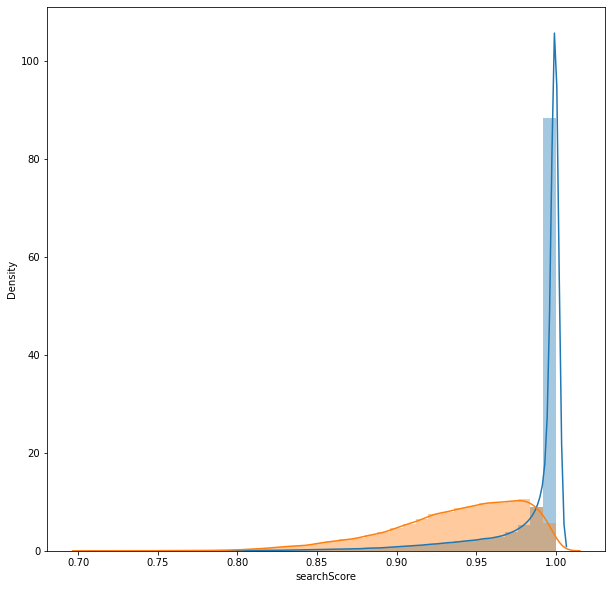

In [130]:
# This plot is for the ditribution of scores of DECOY vs TARGET 

triqler_targets = triqler_peps_df.loc[triqler_peps_df.proteins.str.contains("DECOY") == False]
triqler_decoys = triqler_peps_df.loc[triqler_peps_df.proteins.str.contains("DECOY") == True]

plt.figure(figsize=(10, 10))
sns.distplot(triqler_targets['searchScore'], hist=True, kde=True, 
             bins=int(180/5))
sns.distplot(triqler_decoys['searchScore'], hist=True, kde=True, 
             bins=int(180/5))

<AxesSubplot:ylabel='Sample'>

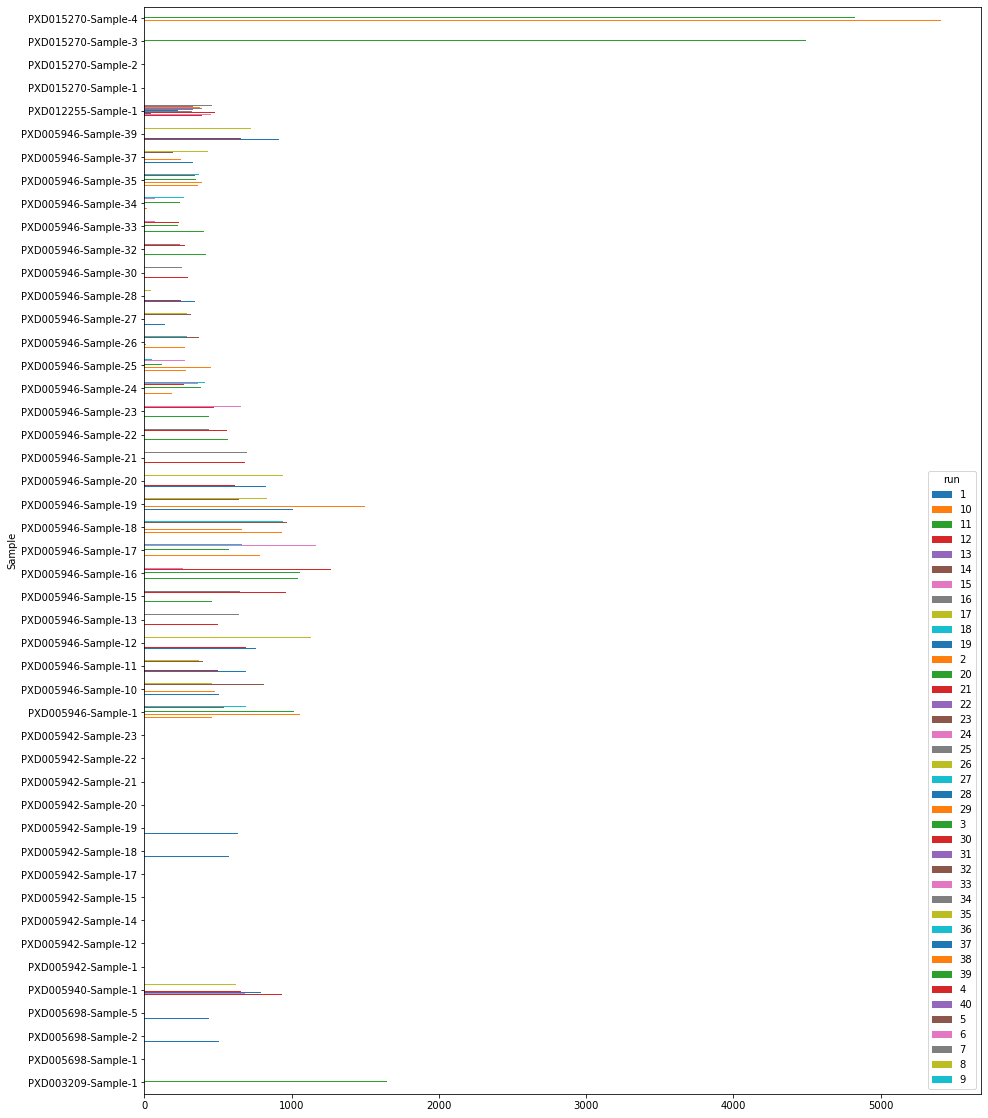

In [49]:
# Print the number of peptides per Sample and ms-run. 

plt.rcParams["figure.figsize"] = [15, 20]
triqler_targets.groupby('run').Sample.value_counts().unstack(0).plot.barh()

In [131]:
conditions = [(triqler_targets['proteins'].str.contains("ENSP") & ~triqler_targets['proteins'].str.contains(conatm_ids)),
        (~(triqler_targets['proteins'].str.contains("ENSP")|triqler_targets['proteins'].str.contains(conatm_ids))
         & triqler_targets['proteins'].str.contains(r"altorf_|pseudo_|ncRNA_")),
        (~(triqler_targets['proteins'].str.contains(r"ENSP|altorf_|pseudo_|ncRNA_") | triqler_targets['proteins'].str.contains(conatm_ids))
         & triqler_targets['proteins'].str.contains(r"COSMIC|cbio")),
        (triqler_targets['proteins'].str.contains(conatm_ids))
             ]
classes = ['canonical', 'non_canonical', 'variant','contaminant']
triqler_targets['Class'] = np.select(conditions, classes)
triqler_targets['Class'].value_counts()

/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


canonical        321111
non_canonical     35629
contaminant       20739
variant             223
Name: Class, dtype: int64

<AxesSubplot:xlabel='Sample'>

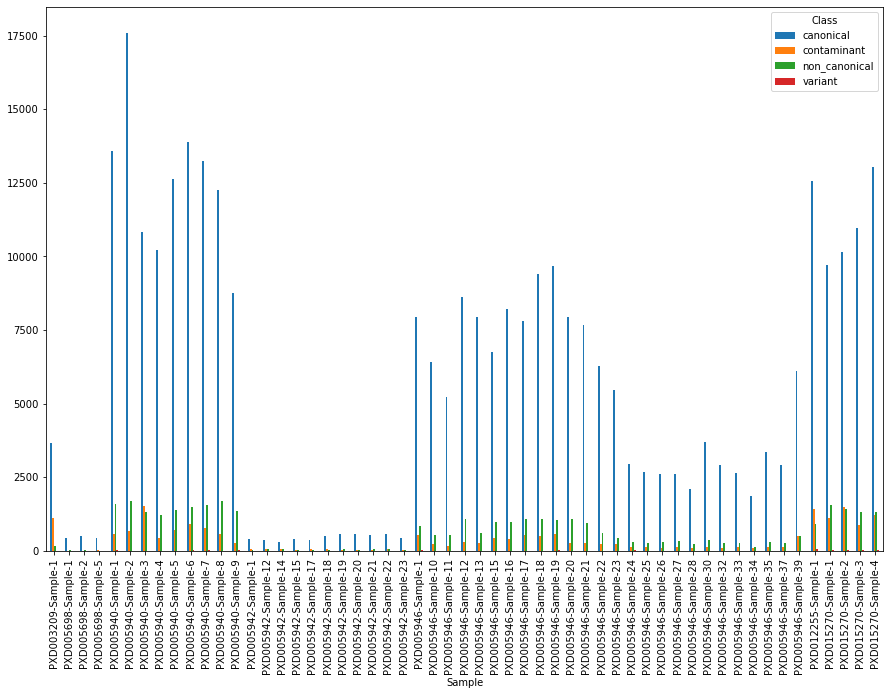

In [132]:
plt.rcParams["figure.figsize"] = [15, 10]
triqler_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [133]:
triqler_targets.to_csv('all_'+triqler_file_name, sep='\t', index=False)

In [134]:
triqler_noncan_targets = triqler_targets[triqler_targets['Class'].str.contains(r"variant|non_canonical")==True]
triqler_noncan_seqs = list(set([rep(x) for x in triqler_noncan_targets['peptide'].tolist()]))

In [136]:
#get non-canonical peptides that are found in canonical proteins
triqler_found_peps = []
auto = ahocorasick.Automaton()
for noncan_seq in triqler_noncan_seqs:
    auto.add_word(noncan_seq, noncan_seq)
auto.make_automaton()
for canseq in allcan_seqs:
    for end_ind, found in auto.iter(canseq):
        triqler_found_peps.append(found)

In [137]:
triqler_noncan_targets = triqler_noncan_targets[triqler_noncan_targets['peptide'].apply(rep).isin(triqler_found_peps)==False]

<AxesSubplot:xlabel='Sample'>

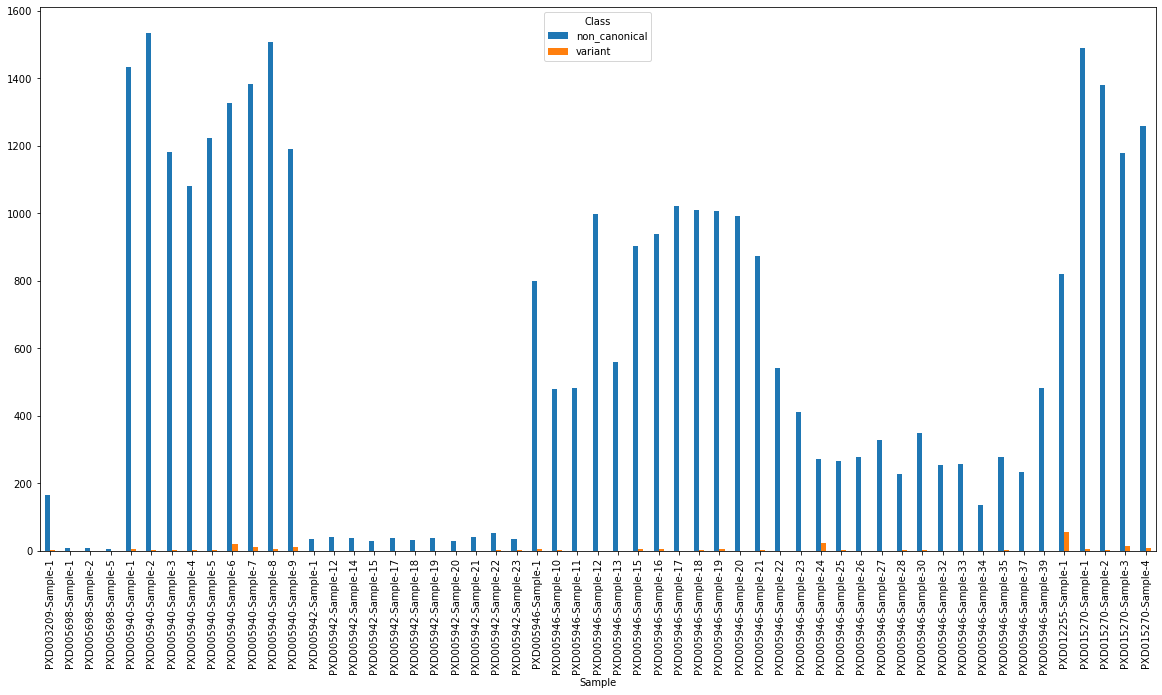

In [138]:
plt.rcParams["figure.figsize"] = [20, 10]
triqler_noncan_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [103]:
'''
                ******mzTabl processing******
'''

'\n                ******mzTabl processing******\n'

In [222]:
#Download mzTab files to a local directory to minimize running time in later runs

#create id output directory if it does not exist
if not os.path.isdir(peps_id_dir):
    os.makedirs(peps_id_dir)
download_files = []
for sample in samples_list:
    try:
        remote_file_size = ftp.size('{}/{}/{}'.format(sample, id_dir, mzTab_file_name))
    except ftplib.error_perm as e: #the search is not done yet!
        print('No file is found for sample {}, error:{}'.format(sample, e))
        continue #to next sample
    
    file_url = 'http://{}/{}/{}/{}/{}'.format(ftp_url, samples_dir, sample, id_dir, mzTab_file_name)
    outfile = '{}/{}_{}'.format(peps_id_dir, sample, mzTab_file_name)
    
    remote_checksum = checksums['{}/{}/{}'.format(sample, id_dir, mzTab_file_name)]
    local_file_size = 0
    local_checksum = ''
    try:
        local_file_size = os.path.getsize(outfile)
        local_checksum = hashlib.md5(open(outfile, 'rb').read()).hexdigest()
    except FileNotFoundError:
        pass
    if local_file_size != remote_file_size or local_checksum!=remote_checksum:
        print('Downloading:', file_url)
        with closing(request.urlopen(file_url)) as r:
            with open(outfile, 'wb') as f:
                shutil.copyfileobj(r, f)
        ftp.sendcmd('PASV')#just to avoid server timeout
    else:
        print('Already exists: ', outfile)
    download_files.append(outfile)

Already exists:  peptide_ids/PXD003209-Sample-1_out.mzTab
Already exists:  peptide_ids/PXD005698-Sample-1_out.mzTab
Already exists:  peptide_ids/PXD005698-Sample-2_out.mzTab
No file is found for sample PXD005698-Sample-4, error:550 Could not get file size.
Already exists:  peptide_ids/PXD005698-Sample-5_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-1_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-2_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-3_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-4_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-5_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-6_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-7_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-8_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-9_out.mzTab
Already exists:  peptide_ids/PXD005942-Sample-1_out.mzTab
Already exists:  peptide_ids/PXD005942-Sample-12_out.mzTab
Already exists:  peptide_ids/PXD005942-Sample-

In [ ]:
#Extract peptides from mzTab files

#get all peptides from the finished samples
mztab_psms_df = pd.DataFrame()
for mzTab_file in glob(peps_id_dir+'/*.mzTab'):
    sample = mzTab_file.split('/')[-1].split('_')[0]
    tables = mztab.MzTab(mzTab_file)#give the mzTab file content
    psms = tables.spectrum_match_table[['sequence', 'accession', 'search_engine_score[1]']]
    psms['Sample'] = sample
    print('Sample {}, #PSMS: {}'.format(sample, len(psms)))
    mztab_psms_df = pd.concat([mztab_psms_df, psms])

In [225]:
mztab_psms_targets.columns

Index(['sequence', 'PSM_ID', 'accession', 'unique', 'database',
       'database_version', 'search_engine', 'search_engine_score[1]',
       'modifications', 'retention_time', 'charge', 'exp_mass_to_charge',
       'calc_mass_to_charge', 'spectra_ref', 'pre', 'post', 'start', 'end',
       'opt_global_FFId_category', 'opt_global_feature_id',
       'opt_global_map_index', 'opt_global_spectrum_reference',
       'opt_global_cv_MS:1000889_peptidoform_sequence',
       'opt_global_Posterior_Error_Probability_score', 'opt_global_q-value',
       'opt_global_cv_MS:1002217_decoy_peptide', 'Sample', 'Class'],
      dtype='object')

In [223]:
print('\nExtracted {} peptides from {} Samples, Avg. Peptides per Sample: {}\n'.format(len(mztab_peps_df), len(set(mztab_peps_df['Sample'])), len(mztab_peps_df)/len(set(mztab_peps_df.Sample))))


Extracted 1807278 peptides from 55 Samples, Avg. Peptides per Sample: 32859.6



In [ ]:
# This plot is for the ditribution of scores of DECOY vs TARGET 
mztab_psms_targets = mztab_psms_df.loc[mztab_psms_df.accession.str.contains("DECOY") == False]
mztab_psms_decoys = mztab_psms_df.loc[mztab_psms_df.accession.str.contains("DECOY") == True]

In [224]:
len(mztab_psms_targets), len(mztab_psms_decoys)

(3247070, 55447)

In [ ]:
plt.figure(figsize=(10, 10))
sns.distplot(mztab_psms_targets['search_engine_score[1]'], hist=True, kde=True, 
             bins=int(180/5), color='green')
sns.distplot(mztab_psms_decoys['search_engine_score[1]'], hist=True, kde=True,
             bins=int(180/5), color = 'red')

In [ ]:
# Print the number of psms per Sample and ms-run. 
plt.rcParams["figure.figsize"] = [15, 20]
mztab_psms_targets.Sample.value_counts().plot.barh()

In [ ]:
conditions = [(mztab_psms_targets['accession'].str.contains("ENSP") & ~mztab_psms_targets['accession'].str.contains(conatm_ids)),
        (~(mztab_psms_targets['accession'].str.contains("ENSP")|mztab_psms_targets['accession'].str.contains(conatm_ids))
         & mztab_psms_targets['accession'].str.contains(r"altorf_|pseudo_|ncRNA_")),
        (~(mztab_psms_targets['accession'].str.contains(r"ENSP|altorf_|pseudo_|ncRNA_") | mztab_psms_targets['accession'].str.contains(conatm_ids))
         & mztab_psms_targets['accession'].str.contains(r"COSMIC|cbio")),
        (mztab_psms_targets['accession'].str.contains(conatm_ids))
             ]
classes = ['canonical', 'non_canonical', 'variant','contaminant']
mztab_psms_targets['Class'] = np.select(conditions, classes)
mztab_psms_targets['Class'].value_counts()

In [ ]:
mztab_psms_targets.to_csv('all_'+mzTab_file_name, sep='\t', index=False)

In [ ]:
mztab_psms_noncan_targets = mztab_psms_targets[mztab_psms_targets['Class'].str.contains(r"variant|non_canonical")==True]
mztab_noncan_seqs = list(set([rep(x) for x in mztab_psms_noncan_targets['sequence'].tolist()]))

In [ ]:
#get non-canonical peptides that are found in canonical proteins
mztab_found_peps = []
auto = ahocorasick.Automaton()
for noncan_seq in mztab_noncan_seqs:
    auto.add_word(noncan_seq, noncan_seq)
auto.make_automaton()
for canseq in allcan_seqs:
    for end_ind, found in auto.iter(canseq):
        mztab_found_peps.append(found)

In [ ]:
mztab_psms_noncan_targets = mztab_psms_noncan_targets[mztab_psms_noncan_targets['sequence'].apply(rep).isin(mztab_found_peps)==False]

In [ ]:
plt.rcParams["figure.figsize"] = [20, 10]
mztab_psms_noncan_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [ ]:
t1=set(mztab_psms_noncan_targets.sequence.apply(rep).tolist())
t2=set(triqler_noncan_targets.peptide.apply(rep).tolist())
inmzTab_notinTriqler = t1-t2
inTriqler_notinmzTab = t2-t1
print('#sequences in mzTab not in triqler {}'.format(len(inmzTab_notinTriqler)))
print('#sequences in triqler not in mzTab {}'.format(len(inTriqler_notinmzTab)))